# Module 3 Final Project - Hypothesis Testing Using Northwind Database

* Student name: Krystian Dennis
* Student pace: Full Time
* Scheduled project review date/time: 19 September 2019 14:00pm 
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@krystiandennis/hypothesis-testing-using-the-northwind-database-c49dd485bd58

## Business Understanding

Northwind Traders is a company that imports and exports specialty foods worldwide. Although there has been a recent increase in sales, profits are down. In this project, we will uncover the root causes of this downtick in profitability and make sound business recommendations based on our findings to set profits on an upward trend. 

We are specifically asked if discounts significantly impact the quantity of items in an order and if so, what level of discount had the greatest impact? We will explore the data to answer these questions and find important relationships in the data provided.

## Northwind Database

Microsoft created the Northwind sample database to demonstrate features of the SQL server and Microsoft Access. The dataset provides a series of tables and their relationships shown below:

<img src='Northwind_ERD_updated.png' height=100% width=100%>

## Import Libraries

In [1]:
!pip install researchpy

import sqlite3 
import pandas as pd

import numpy as np

from scipy import stats
from scipy.stats import t

from statistics import mean, stdev

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.power import TTestIndPower, TTestPower

import researchpy as rp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings("ignore")

pexpect 4.6.0 requires ptyprocess>=0.5, which is not installed.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
table_names = [x[0] for x in c.execute("SELECT name from sqlite_master WHERE type ='table';").fetchall()]
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [4]:
c.execute("""SELECT [Order].Id, OrderDate, (UnitPrice*Quantity) AS 'Sales Total'
               FROM OrderDetail
               JOIN [Order]
               ON [Order].Id = OrderDetail.OrderId
               ORDER BY ProductId;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
display(df.head())
display(df.info())
display(df.describe())
np.shape(df)

,Id,OrderDate,Sales Total
0,10285,2012-08-20,648.0
1,10294,2012-08-30,259.2
2,10317,2012-09-30,288.0
3,10348,2012-11-07,216.0
4,10354,2012-11-14,172.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
Id             2155 non-null int64
OrderDate      2155 non-null object
Sales Total    2155 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 50.6+ KB


None

,Id,Sales Total
count,2155.000000,2155.000000
mean,10659.375870,628.519067
std,241.378032,1036.466980
min,10248.000000,4.800000
25%,10451.000000,154.000000
50%,10657.000000,360.000000
75%,10862.500000,722.250000
max,11077.000000,15810.000000


(2155, 3)

In [5]:
df['date_of_order'] = pd.to_datetime(df['OrderDate']).dt.to_period('M')

Text(0, 0.5, 'Total Sales in Dollars\n')

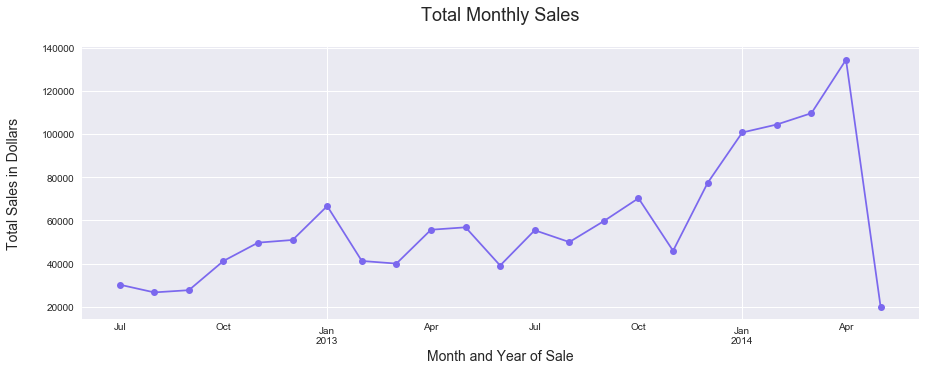

In [6]:
plt.figure(figsize=(15,5))
df.groupby(['date_of_order']).sum()['Sales Total'].plot(color='#7B68EE', marker='o')
plt.title('Total Monthly Sales\n', fontsize = 18)
plt.xlabel('Month and Year of Sale\n', fontsize = 14)
plt.ylabel('Total Sales in Dollars\n', fontsize = 14)

## Hypothesis Test 1

## Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Part 1 - Discount vs. No Discount

> $H_0$: Discounts do not have a statistically significant effect on the quantity of products customers order.

> $H_1$: Discounts do have a statistically significant impact on the number of products customers order.

> $\alpha$ = 0.05

In [7]:
c.execute("""SELECT Quantity, Discount, OrderDetail.UnitPrice, ProductId, CategoryId, CategoryName
               FROM OrderDetail
               JOIN Product
               ON ProductId = Product.Id
               JOIN Category 
               ON CategoryId = Category.Id 
               ORDER BY ProductId;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
display(df.head())
display(df.info())
display(df.describe())
np.shape(df)

,Quantity,Discount,UnitPrice,ProductId,CategoryId,CategoryName
0,45,0.20,14.4,1,1,Beverages
1,18,0.00,14.4,1,1,Beverages
2,20,0.00,14.4,1,1,Beverages
3,15,0.15,14.4,1,1,Beverages
4,12,0.00,14.4,1,1,Beverages


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Quantity        2155 non-null int64
Discount        2155 non-null float64
UnitPrice       2155 non-null float64
ProductId       2155 non-null int64
CategoryId      2155 non-null int64
CategoryName    2155 non-null object
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


None

,Quantity,Discount,UnitPrice,ProductId,CategoryId
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,23.812993,0.056167,26.218520,40.793039,4.135499
std,19.022047,0.083450,29.827418,22.159019,2.378567
min,1.000000,0.000000,2.000000,1.000000,1.000000
25%,10.000000,0.000000,12.000000,22.000000,2.000000
50%,20.000000,0.000000,18.400000,41.000000,4.000000
75%,30.000000,0.100000,32.000000,60.000000,6.000000
max,130.000000,0.250000,263.500000,77.000000,8.000000


(2155, 6)

In [8]:
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [9]:
drop = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df['Discount'].isin(drop)]

In [10]:
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [11]:
no_discount = df.loc[df['Discount'] == 0, 'Quantity']
no_discount.head()

1    18
2    20
4    12
6    10
7    24
Name: Quantity, dtype: int64

In [12]:
discount = df.loc[df['Discount'] != 0, 'Quantity']
discount.head()

0     45
3     15
5     15
9     40
10     8
Name: Quantity, dtype: int64

In [13]:
df['Has Discount'] = (df['Discount'] != 0)

(0, 9)

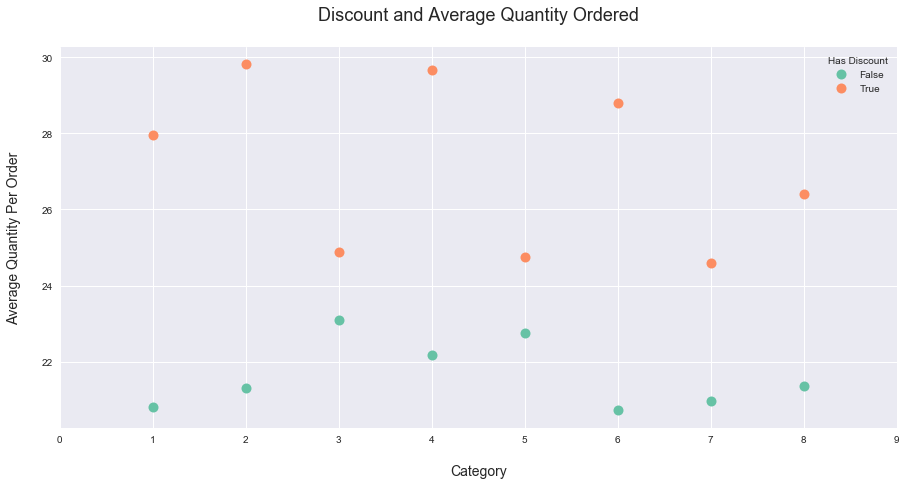

In [14]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['CategoryId', 'Has Discount']).mean()['Quantity'].unstack().plot(ax=ax, marker='o', linestyle='', ms=10)
plt.xlabel('\nCategory', fontsize = 14)
plt.ylabel('Average Quantity Per Order\n', fontsize = 14)
plt.title('Discount and Average Quantity Ordered\n', fontsize = 18)
ax.set_xlim(0,9)

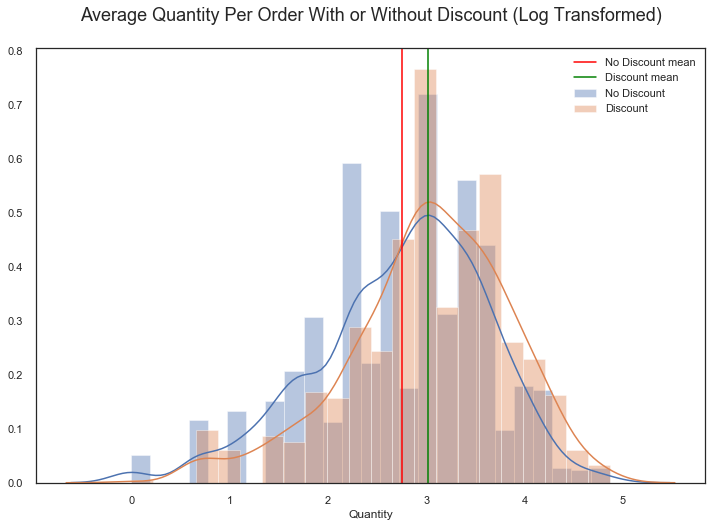

In [15]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('white')
sns.distplot(np.log(no_discount), label='No Discount')
sns.distplot(np.log(discount), label='Discount')
plt.axvline(np.mean(np.log(no_discount)), color='#FF0000', label='No Discount mean')
plt.axvline(np.mean(np.log(discount)), color='#008000', label='Discount mean')
plt.title('Average Quantity Per Order With or Without Discount (Log Transformed)\n', fontsize = 18)
plt.legend()
plt.show();

Text(0, 0.5, '')

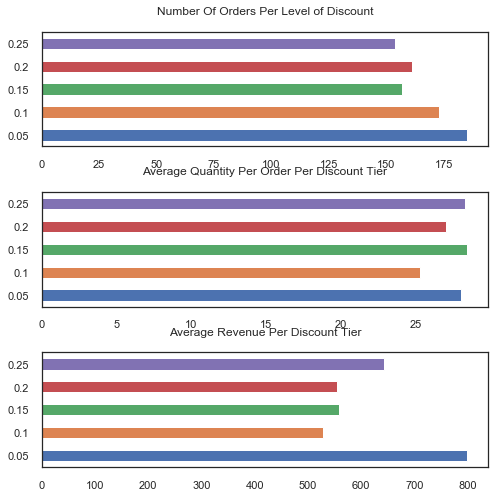

In [16]:
df_discounts = df.drop(df[(df['Discount'] == 0.00)].index)
df_discounts['OrderTotal'] = df['Quantity']*(df['UnitPrice']*(1-df['Discount']))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
fig.subplots_adjust(hspace=0.4);
df_discounts.groupby(['Discount'])['Discount'].count().plot(kind='barh', ax=ax1)
df_discounts.groupby(['Discount'])['Quantity'].mean().plot(kind='barh', ax=ax2)
df_discounts.groupby(['Discount'])['OrderTotal'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Number Of Orders Per Level of Discount\n')
ax1.set_ylabel('')
ax2.set_title('\nAverage Quantity Per Order Per Discount Tier\n')
ax2.set_ylabel('')
ax3.set_title('\nAverage Revenue Per Discount Tier\n')
ax3.set_ylabel('')

In [17]:
no_discount_mean = np.mean(no_discount)
discount_mean = np.mean(discount)
mean_difference = discount_mean - no_discount_mean
round(discount_mean,2), round(no_discount_mean,2), round(mean_difference,2)

(27.35, 21.72, 5.64)

In [18]:
alpha = 0.05

Testing for Normality

In [19]:
#distribution not normal
stats.shapiro(discount)

(0.8673426508903503, 6.471277454941499e-26)

In [20]:
#distribution not normal
stats.shapiro(no_discount)

(0.8434571027755737, 3.803856556577728e-34)

Testing for Homogeneity of Variance

In [21]:
# perform Levene test for homogeneity of variance
# variance not homogeneous
stats.levene(discount, no_discount)

LeveneResult(statistic=14.296405109976126, pvalue=0.0001604308631855048)

Welch's T Test

In [22]:
#welch's t done in researchpy 
#equal_variances = False to perform Welch's T Test
descriptives, results = rp.ttest(discount, no_discount, equal_variances=False)
display(descriptives)
results

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,830.0,27.354217,20.720667,0.719225,25.942501,28.765933
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,2147.0,23.895203,19.009580,0.410257,23.090659,24.699746


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,5.6390
1,Degrees of freedom =,1545.6758
2,t =,6.5112
3,Two side test p value =,0.0000
4,Difference > 0 p value =,1.0000
5,Difference < 0 p value =,0.0000
6,Cohen's d =,0.2886
7,Hedge's g =,0.2885
8,Glass's delta =,0.2721
9,r =,0.1634


In [23]:
#t-critical value 
print ('t-critical value:',t.ppf(1 - 0.05, df=1546))

#t value > t-critical value: difference is significant 

t-critical value: 1.6458398418218587


In [24]:
power = TTestIndPower()
power_discount = power.power(effect_size=0.2886, nobs1=len(discount), alpha=alpha, ratio=len(no_discount)/len(discount), df=(len(discount) -1 + len(no_discount)-1), alternative='larger')
power_discount

0.9999999999629137

In [25]:
no_discount.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [26]:
discount.describe()

count    830.000000
mean      27.354217
std       20.720667
min        1.000000
25%       12.250000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

- t value: 6.5112
- t-critical value: 1.6458398418218587
- p-value : 0.000 
- cohen's d: 0.2886, small effect
- power = 0.9999999999629137

> $H_0$: Discounts do not have a statistically significant effect on the quantity of products customers order.

> $H_1$: Discounts do have a statistically significant impact on the number of products customers order.
    
The findings are statistically significant! **We can reject the null hypothesis in support of the alternative.** We can say with 95% confidence that the mean quantity of products ordered is larger when there is a discount offered. 

We will take a look now as to how the level of discount effects sales.

### Part 2 - Level of Discount

> $H_0$: Level of discount doesn not affect the quantity of products customers order.

> $H_1$: Level of discount significantly impacts the number of products customers order.

> $\alpha$ = 0.05

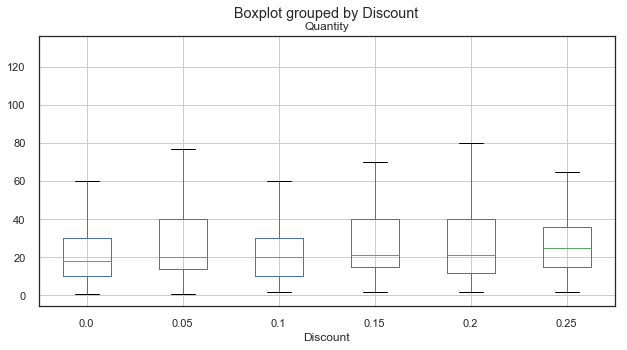

In [27]:
df.boxplot('Quantity', by='Discount', figsize=(10, 5));

In [28]:
disc_00 = df.loc[df['Discount'] == 0.00, 'Quantity']
disc_05 = df.loc[df['Discount'] == 0.05, 'Quantity']
disc_10 = df.loc[df['Discount'] == 0.10, 'Quantity']
disc_15 = df.loc[df['Discount'] == 0.15, 'Quantity']
disc_20 = df.loc[df['Discount'] == 0.20, 'Quantity']
disc_25 = df.loc[df['Discount'] == 0.25, 'Quantity']

In [29]:
stats.levene(disc_00,disc_05, disc_10, disc_15, disc_20, disc_25)

LeveneResult(statistic=2.9943951679841643, pvalue=0.010664285577385134)

In [30]:
stats.shapiro(disc_00)

(0.8434571027755737, 3.803856556577728e-34)

In [31]:
stats.shapiro(disc_05)

(0.8356332778930664, 3.5543719660233175e-13)

In [32]:
stats.shapiro(disc_10)

(0.8002723455429077, 4.159971249851485e-14)

In [33]:
stats.shapiro(disc_15)

(0.8827876448631287, 8.372069704165597e-10)

In [34]:
stats.shapiro(disc_20)

(0.9130357503890991, 3.249125413162801e-08)

In [35]:
stats.shapiro(disc_25)

(0.8902021646499634, 2.6962121424389807e-09)

In [36]:
descriptives, results = rp.ttest(disc_05, disc_00, equal_variances=False)
print('5% Discount:\n')
display(descriptives)
results

5% Discount:



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,185.0,28.010811,22.187685,1.631271,24.792410,31.229212
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,1502.0,22.490679,18.258295,0.471113,21.566569,23.414789


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,6.2955
1,Degrees of freedom =,217.3603
2,t =,3.7008
3,Two side test p value =,0.0003
4,Difference > 0 p value =,0.9999
5,Difference < 0 p value =,0.0001
6,Cohen's d =,0.2906
7,Hedge's g =,0.2904
8,Glass's delta =,0.2837
9,r =,0.2435


In [37]:
descriptives, results = rp.ttest(disc_10, disc_00, equal_variances=False)
print('10% Discount:\n')
display(descriptives)
results

10% Discount:



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,173.0,25.236994,21.186503,1.610780,22.057553,28.416436
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,1490.0,22.124161,18.000672,0.466332,21.209423,23.038899


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,3.5217
1,Degrees of freedom =,204.0260
2,t =,2.0944
3,Two side test p value =,0.0375
4,Difference > 0 p value =,0.9813
5,Difference < 0 p value =,0.0187
6,Cohen's d =,0.1694
7,Hedge's g =,0.1693
8,Glass's delta =,0.1662
9,r =,0.1451


In [38]:
descriptives, results = rp.ttest(disc_15, disc_00, equal_variances=False)
print('15% Discount:\n')
display(descriptives)
results

15% Discount:



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,157.0,28.382166,20.923099,1.669845,25.083741,31.680590
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,1474.0,22.425373,18.012184,0.469156,21.505087,23.345659


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,6.6669
1,Degrees of freedom =,182.9771
2,t =,3.8357
3,Two side test p value =,0.0002
4,Difference > 0 p value =,0.9999
5,Difference < 0 p value =,0.0001
6,Cohen's d =,0.3239
7,Hedge's g =,0.3237
8,Glass's delta =,0.3186
9,r =,0.2728


In [39]:
descriptives, results = rp.ttest(disc_20, disc_00, equal_variances=False)
print('20% Discount:\n')
display(descriptives)
results

20% Discount:



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,161.0,27.024845,18.832801,1.484233,24.093631,29.956058
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,1478.0,22.293640,17.727390,0.461113,21.389134,23.198147


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,5.3096
1,Degrees of freedom =,195.3279
2,t =,3.4021
3,Two side test p value =,0.0008
4,Difference > 0 p value =,0.9996
5,Difference < 0 p value =,0.0004
6,Cohen's d =,0.2840
7,Hedge's g =,0.2839
8,Glass's delta =,0.2819
9,r =,0.2365


In [40]:
descriptives, results = rp.ttest(disc_25, disc_00, equal_variances=False)
print('25% Discount:\n')
display(descriptives)
results

25% Discount:



,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,154.0,28.240260,20.120570,1.621362,25.037113,31.443406
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,1471.0,22.398368,17.903379,0.466798,21.482708,23.314029


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,6.5250
1,Degrees of freedom =,181.1251
2,t =,3.8573
3,Two side test p value =,0.0002
4,Difference > 0 p value =,0.9999
5,Difference < 0 p value =,0.0001
6,Cohen's d =,0.3285
7,Hedge's g =,0.3283
8,Glass's delta =,0.3243
9,r =,0.2755


In [41]:
results = ols('Quantity ~ C(Discount)', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.799
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           2.84e-09
Time:                        10:11:37   Log-Likelihood:                -9344.5
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2141   BIC:                         1.873e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              21.7153      0.519     41.879      0.000      20.698      22.732
C(Discount)[T.0.05]     6.2955      1.477      4.261      0.000       3.398       9.193
C(Discount)[T.0.1]      3.5217      1.522      2.314      0.021       0.537       6.506
C(Discount)[T.0.15]     6.6669      1.589      4.196      0.000       3.551       9.783
C(Discount)[T.0.2]      5.3096      1.571      3.380      0.001       2.229       8.391
C(Discount)[T.0.25]     6.5250      1.603      4.072      0.000       3.382       9.668
==============================================================================
Omnibus:                      784.809   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3071.552
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                       7.670   Cond. No.                         4.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Discount),17348.854662,5.0,9.798709,2.840681e-09
Residual,758138.565924,2141.0,NaN,NaN


In [43]:
print ('f-critical value:',stats.f.cdf(1-0.05, dfn=4, dfd=1546))

f-critical value: 0.5659370686113215


In [44]:
def anova_effect_size(aov):       
    """ This function takes the Anova table performed with statsmodels
    and appends two effect size measures: eta-squared and omega-squared. """
    
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_effect_size(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Discount),17348.854662,5.0,3469.770932,9.798709,2.840681e-09,0.022372,0.020079
Residual,758138.565924,2141.0,354.104888,NaN,NaN,NaN,NaN


In [45]:
results.diagn

{'jb': 3071.5520898739655,
 'jbpv': 0.0,
 'skew': 1.7699049877236657,
 'kurtosis': 7.669555411350016,
 'omni': 784.8094785378735,
 'omnipv': 3.8087903033670104e-171,
 'condno': 4.750871046284668,
 'mineigval': 98.11946438447124}

In [46]:
mc = MultiComparison(df['Quantity'], df['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


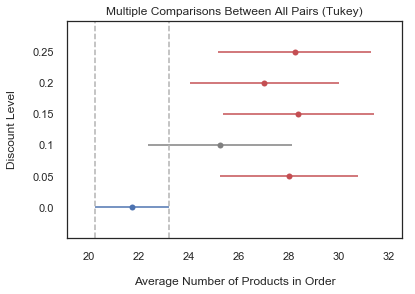

In [47]:
mc_results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

In [48]:
power = TTestIndPower()
power_05 = power.power(effect_size=0.2906, nobs1=len(disc_05), alpha=alpha, ratio=len(disc_00)/len(disc_05), df=(len(disc_05) -1 + len(disc_00)-1), alternative='larger')
power_10 = power.power(effect_size=0.1694, nobs1=len(disc_10), alpha=alpha, ratio=len(disc_00)/len(disc_10), df=(len(disc_10) -1 + len(disc_00)-1), alternative='larger')
power_15 = power.power(effect_size=0.3239, nobs1=len(disc_15), alpha=alpha, ratio=len(disc_00)/len(disc_15), df=(len(disc_15) -1 + len(disc_00)-1), alternative='larger')
power_20 = power.power(effect_size=0.2840, nobs1=len(disc_20), alpha=alpha, ratio=len(disc_00)/len(disc_20), df=(len(disc_20) -1 + len(disc_00)-1), alternative='larger')
power_25 = power.power(effect_size=0.3285, nobs1=len(disc_25), alpha=alpha, ratio=len(disc_00)/len(disc_25), df=(len(disc_25) -1 + len(disc_00)-1), alternative='larger')

power_05, power_10, power_15, power_20, power_25

(0.9800435616692902,
 0.6732709538031703,
 0.9857239082222566,
 0.9603888003569658,
 0.9864702641918153)

- f value: 9.798709
- f-critical value: 0.5659370686113215
- $\eta^2$: 0.022372, small effect
- $\omega^2$: 0.020079, small effect
- p-value : 0.610041445360832
- cohen's d: 
    * 05% = 0.2906
    * 10% = 0.1694
    * 15% = 0.3239
    * 20% = 0.2840
    * 25% = 0.3285
- power:
    * 05% = 0.9800435616692902
    * 10% = 0.6732709538031703
    * 15% = 0.9857239082222566
    * 20% = 0.9603888003569658
    * 25% = 0.9864702641918153
    
> $H_0$: Level of discount does not affect the quantity of products customers order.

> $H_1$: Level of discount significantly impacts the number of products customers order.

The findings are not significant! **We can fail to reject the null hypothesis and reject the alternative.** The level of discount does not have a statistically significant effect of the quantity of products customers order. It seems that the number of items can't be increased by offering a discount higher than 0.05. 

There is some evidence that a discount of 0.1 may be less productive than one of 0.15 or 0.25 (double-digits).The results of Tukey's tests suggest that applying a product discount of 5, 15, 20, or 25 percent encourages customers to order products in higher quantities.

The results can be used to investigate how discounts should be used to generate more revenue and which employees are overusing discounts to generate sales. 

## Hypothesis Test 2 

## Order Total and Discount

> $H_0$: Discount has no impact on order total.

> $H_1$: Discount significantly impacts order total.

> $\alpha$ = 0.05

In [49]:
c.execute("""SELECT [Order].Id,
            OrderDetail.Quantity, OrderDetail.UnitPrice, OrderDetail.Discount, ProductId, CategoryId
            FROM OrderDetail
            JOIN [Order]
            ON [Order].Id = OrderDetail.OrderId
            INNER JOIN Product
            ON Product.Id = OrderDetail.ProductId
            JOIN Category
            ON CategoryId = Category.Id
            WHERE Discount != 0.06 AND Discount > 0.04 OR Discount = 0.00
            GROUP BY [Order].Id
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
display(df.head())
display(df.info())
display(df.describe())
np.shape(df)

,Id,Quantity,UnitPrice,Discount,ProductId,CategoryId
0,10248,5,34.8,0.00,72,4
1,10249,40,42.4,0.00,51,7
2,10250,15,16.8,0.15,65,2
3,10251,20,16.8,0.00,65,2
4,10252,40,27.2,0.00,60,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 6 columns):
Id            830 non-null int64
Quantity      830 non-null int64
UnitPrice     830 non-null float64
Discount      830 non-null float64
ProductId     830 non-null int64
CategoryId    830 non-null int64
dtypes: float64(2), int64(4)
memory usage: 39.0 KB


None

,Id,Quantity,UnitPrice,Discount,ProductId,CategoryId
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,10662.500000,22.883133,24.868578,0.054157,55.489157,3.878313
std,239.744656,18.952727,25.800797,0.082725,18.093891,2.259068
min,10248.000000,1.000000,2.000000,0.000000,1.000000,1.000000
25%,10455.250000,10.000000,12.000000,0.000000,43.000000,2.000000
50%,10662.500000,20.000000,18.000000,0.000000,60.000000,4.000000
75%,10869.750000,30.000000,33.250000,0.100000,71.000000,5.000000
max,11077.000000,130.000000,263.500000,0.250000,77.000000,8.000000


(830, 6)

In [50]:
print(df['Id'].nunique())
print(len(df['Id']))

830
830


In [51]:
df['OrderTotal'] = df['Quantity']*(df['UnitPrice']*(1-df['Discount']))
df.head()

,Id,Quantity,UnitPrice,Discount,ProductId,CategoryId,OrderTotal
0,10248,5,34.8,0.00,72,4,174.0
1,10249,40,42.4,0.00,51,7,1696.0
2,10250,15,16.8,0.15,65,2,214.2
3,10251,20,16.8,0.00,65,2,336.0
4,10252,40,27.2,0.00,60,4,1088.0


In [52]:
df['Sales Before Discount'] = df['Quantity']*df['UnitPrice']
df['Has Discount'] = (df['Discount'] != 0)
df.head()

,Id,Quantity,UnitPrice,Discount,ProductId,CategoryId,OrderTotal,Sales Before Discount,Has Discount
0,10248,5,34.8,0.00,72,4,174.0,174.0,False
1,10249,40,42.4,0.00,51,7,1696.0,1696.0,False
2,10250,15,16.8,0.15,65,2,214.2,252.0,True
3,10251,20,16.8,0.00,65,2,336.0,336.0,False
4,10252,40,27.2,0.00,60,4,1088.0,1088.0,False


In [53]:
disc_00 = df.loc[df['Discount'] == 0.00]
disc_05 = df.loc[df['Discount'] == 0.05]
disc_10 = df.loc[df['Discount'] == 0.10]
disc_15 = df.loc[df['Discount'] == 0.15]
disc_20 = df.loc[df['Discount'] == 0.20]
disc_25 = df.loc[df['Discount'] == 0.25]

In [54]:
disc_05['OrderTotal'].describe()

count      70.000000
mean      740.069679
std       871.353769
min        47.500000
25%       294.975000
50%       453.720000
75%       878.750000
max      6042.000000
Name: OrderTotal, dtype: float64

(0, 9)

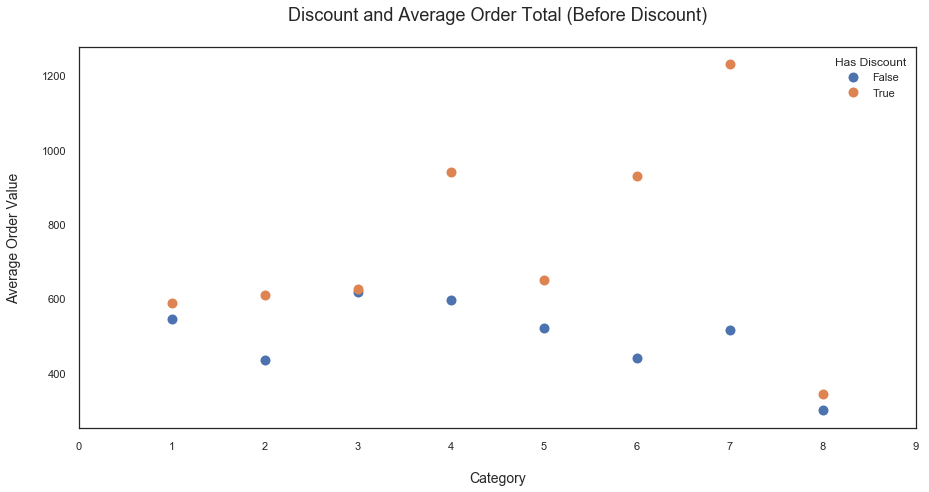

In [55]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['CategoryId', 'Has Discount']).mean()['Sales Before Discount'].unstack().plot(ax=ax, marker='o', linestyle='', ms=10)
plt.xlabel('\nCategory', fontsize = 14)
plt.ylabel('Average Order Value\n', fontsize = 14)
plt.title('Discount and Average Order Total (Before Discount)\n', fontsize = 18)
ax.set_xlim(0,9)

In [56]:
not_discounted = df.loc[df['Discount'] == 0]
not_discounted.head()

,Id,Quantity,UnitPrice,Discount,ProductId,CategoryId,OrderTotal,Sales Before Discount,Has Discount
0,10248,5,34.8,0.0,72,4,174.0,174.0,False
1,10249,40,42.4,0.0,51,7,1696.0,1696.0,False
3,10251,20,16.8,0.0,65,2,336.0,336.0,False
4,10252,40,27.2,0.0,60,4,1088.0,1088.0,False
5,10253,40,16.0,0.0,49,3,640.0,640.0,False


In [57]:
discounted = df.loc[df['Discount'] != 0]
discounted.head()

,Id,Quantity,UnitPrice,Discount,ProductId,CategoryId,OrderTotal,Sales Before Discount,Has Discount
2,10250,15,16.8,0.15,65,2,214.200,252.0,True
10,10258,6,25.6,0.20,32,4,122.880,153.6,True
12,10260,21,12.0,0.25,70,1,189.000,252.0,True
15,10263,36,8.0,0.25,74,7,216.000,288.0,True
16,10264,25,7.7,0.15,41,8,163.625,192.5,True


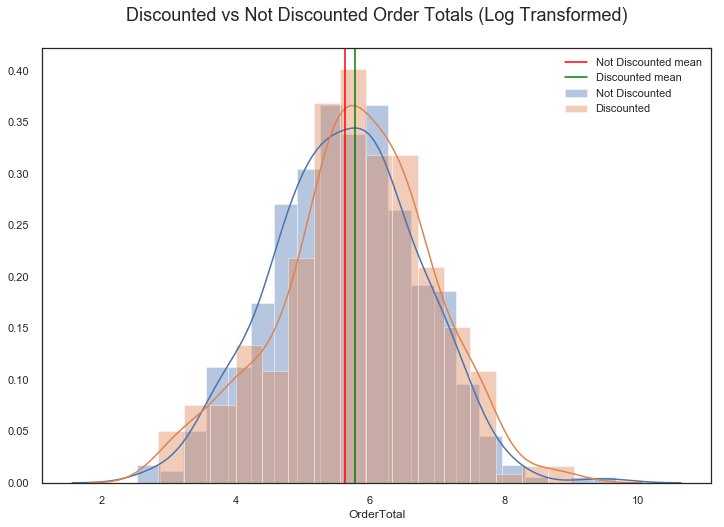

In [58]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('white')
sns.distplot(np.log(not_discounted["OrderTotal"]), label = 'Not Discounted')
sns.distplot(np.log(discounted['OrderTotal']), label = 'Discounted')
plt.axvline(np.mean(np.log(not_discounted['OrderTotal'])), color='#FF0000', label = 'Not Discounted mean')
plt.axvline(np.mean(np.log(discounted['OrderTotal'])), color='#008000', label = 'Discounted mean')
plt.title('Discounted vs Not Discounted Order Totals (Log Transformed)\n', fontsize = 18)
plt.legend()
plt.show();

Testing for Homogeneity of Variance

In [59]:
#homogeneous 
stats.levene(not_discounted['OrderTotal'], discounted['OrderTotal'])

LeveneResult(statistic=0.5314857450805779, pvalue=0.46618904603320965)

Testing for Normality

In [60]:
#not normal
stats.shapiro(not_discounted['OrderTotal'])

(0.37367695569992065, 7.959522413703715e-39)

In [61]:
#not normal
stats.shapiro(discounted['OrderTotal'])

(0.5636283159255981, 4.714796296702494e-27)

In [62]:
descriptives, results = rp.ttest(discounted['OrderTotal'], not_discounted['OrderTotal'], equal_variances = True)
display(descriptives)
results

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,OrderTotal,308.0,591.426547,847.375023,48.283673,496.417736,686.435358
1,OrderTotal,522.0,517.180460,971.579167,42.524865,433.639185,600.721735
2,combined,830.0,544.732020,927.604908,32.197636,481.533543,607.930497


,Independent t-test,results
0,Difference (OrderTotal - OrderTotal) =,74.2461
1,Degrees of freedom =,828.0000
2,t =,1.1142
3,Two side test p value =,0.2655
4,Difference > 0 p value =,0.8672
5,Difference < 0 p value =,0.1328
6,Cohen's d =,0.0801
7,Hedge's g =,0.0800
8,Glass's delta =,0.0876
9,r =,0.0387


In [63]:
#t-critical value 
print ('t-critical value:',t.ppf(1 - 0.05, df=828))

t-critical value: 1.6466960011098632


In [64]:
power = TTestIndPower()
power_order_total = power.power(effect_size=0.3948744653331997, nobs1=len(discounted['OrderTotal']), alpha=alpha, ratio=len(not_discounted['OrderTotal'])/len(discounted['OrderTotal']), df=(len(discounted['OrderTotal']) -1 + len(not_discounted['OrderTotal'])-1), alternative='larger')
power_order_total

0.9999999805524182

In [65]:
discounted['OrderTotal'].describe() 

count     308.000000
mean      591.426547
std       847.375023
min        17.000000
25%       173.310000
50%       334.000000
75%       678.250000
max      8432.000000
Name: OrderTotal, dtype: float64

In [66]:
not_discounted['OrderTotal'].describe()

count      522.000000
mean       517.180460
std        971.579167
min         12.500000
25%        135.025000
50%        285.000000
75%        567.500000
max      15810.000000
Name: OrderTotal, dtype: float64

- t value: 1.1142
- t-critical value: 1.6466960011098632
- p-value : 0.2655
- cohen's d: 0.0801, small effect
- power: 0.9999999805524182

> $H_0$: Discount does not have a statistically significant impact on order total.

> $H_1$: Discount has a statistically significant impact on order total.
    
The findings are not significant! **We can fail to reject the null hypothesis and reject the alternative.** Offering a discount does not have a statistically significant impact on order total. The average order total for discounted orders was $542.93, while orders withour discounts averaged $517.18. 

The results may be used to determine when and if discounts should be offered in order to incentivize higher sales. Restrictions may need to be placed on when discounts are given. 

## Hypothesis Test 3 

## Customer Loyalty

> $H_0$: People who order more frequently do not spend more money on average than people who order less frequently.

> $H_1$: People who order more frequently spend more money on average than people who order less frequently.

> $\alpha$ = 0.05

In [67]:
c.execute('''SELECT c.Id customer_id, o.Id order_id,
                            od.Quantity Quantity, od.UnitPrice UnitPrice, od.Discount Discount
                            FROM OrderDetail od 
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Customer c ON o.CustomerId = c.Id
                            ORDER BY CustomerId 
                            ;''')
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
display(df.head())
display(df.info())
display(df.describe())
np.shape(df)

,customer_id,order_id,Quantity,UnitPrice,Discount
0,ALFKI,10643,15,45.6,0.25
1,ALFKI,10643,21,18.0,0.25
2,ALFKI,10643,2,12.0,0.25
3,ALFKI,10692,20,43.9,0.00
4,ALFKI,10702,6,10.0,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 5 columns):
customer_id    2078 non-null object
order_id       2078 non-null int64
Quantity       2078 non-null int64
UnitPrice      2078 non-null float64
Discount       2078 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 81.2+ KB


None

,order_id,Quantity,UnitPrice,Discount
count,2078.000000,2078.000000,2078.000000,2078.000000
mean,10658.376323,23.924447,26.277416,0.056035
std,242.371015,19.151339,29.962501,0.083421
min,10248.000000,1.000000,2.000000,0.000000
25%,10449.000000,10.000000,12.000000,0.000000
50%,10656.000000,20.000000,18.400000,0.000000
75%,10861.000000,30.000000,32.000000,0.100000
max,11077.000000,130.000000,263.500000,0.250000


(2078, 5)

In [68]:
df.isna().sum()

customer_id    0
order_id       0
Quantity       0
UnitPrice      0
Discount       0
dtype: int64

In [69]:
df['OrderTotal'] = df['Quantity']*(df['UnitPrice']*(1-df['Discount']))
display(df.head())
display(df.info())

,customer_id,order_id,Quantity,UnitPrice,Discount,OrderTotal
0,ALFKI,10643,15,45.6,0.25,513.0
1,ALFKI,10643,21,18.0,0.25,283.5
2,ALFKI,10643,2,12.0,0.25,18.0
3,ALFKI,10692,20,43.9,0.00,878.0
4,ALFKI,10702,6,10.0,0.00,60.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 6 columns):
customer_id    2078 non-null object
order_id       2078 non-null int64
Quantity       2078 non-null int64
UnitPrice      2078 non-null float64
Discount       2078 non-null float64
OrderTotal     2078 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 97.5+ KB


None

In [70]:
mean = np.mean(df.groupby('customer_id')['order_id'].count())
median = np.median(df.groupby('customer_id')['order_id'].count())
print('Mean:', mean)
print('Median:', median)

Mean: 24.44705882352941
Median: 20.0


In [71]:
new_dataframe = pd.DataFrame(df.groupby('customer_id')['order_id'].count())
new_dataframe.rename(columns={'order_id':'Number of Orders'}, inplace=True)
new_dataframe['Order Frequency'] = new_dataframe['Number of Orders'].apply(lambda x: 'Below Median' 
                                                                           if x <= median 
                                                                           else 'Above Median')
new_dataframe['Total Spend'] = df.groupby('customer_id')['OrderTotal'].sum()
display(new_dataframe.head())
new_dataframe.describe()

,Number of Orders,Order Frequency,Total Spend
customer_id,,,
ALFKI,12,Below Median,4273.0000
ANATR,10,Below Median,1402.9500
AROUT,30,Above Median,13390.6500
BERGS,52,Above Median,24927.5775
BLAUS,14,Below Median,3239.8000


,Number of Orders,Total Spend
count,85.000000,85.000000
mean,24.447059,14446.770171
std,20.049050,20562.051784
min,2.000000,100.800000
25%,11.000000,3239.800000
50%,20.000000,7176.215000
75%,31.000000,16817.097500
max,116.000000,110277.305000


In [72]:
below_median = new_dataframe.loc[new_dataframe['Order Frequency'] == 'Below Median']
above_median = new_dataframe.loc[new_dataframe['Order Frequency'] == 'Above Median']
display(below_median.head())
above_median.head()

,Number of Orders,Order Frequency,Total Spend
customer_id,,,
ALFKI,12,Below Median,4273.00
ANATR,10,Below Median,1402.95
BLAUS,14,Below Median,3239.80
BOLID,6,Below Median,4232.85
CACTU,11,Below Median,1814.80


,Number of Orders,Order Frequency,Total Spend
customer_id,,,
AROUT,30,Above Median,13390.6500
BERGS,52,Above Median,24927.5775
BLONP,26,Above Median,18534.0800
BONAP,44,Above Median,21963.2525
BOTTM,35,Above Median,20801.6000


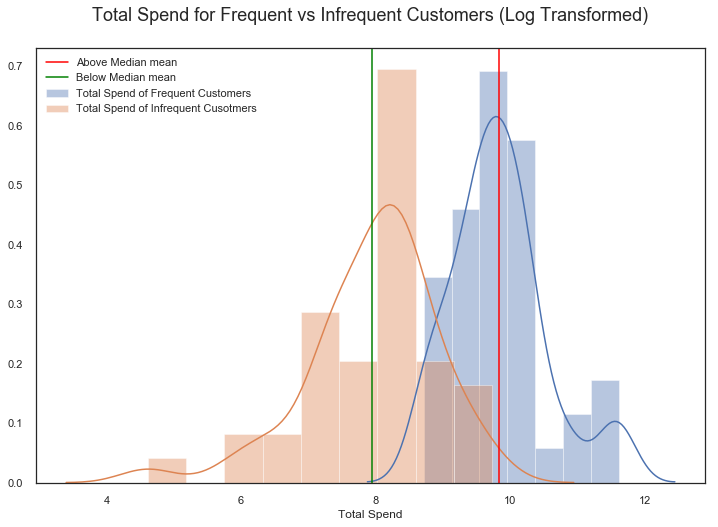

In [73]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('white')
sns.distplot(np.log(above_median['Total Spend']), label='Total Spend of Frequent Customers')
sns.distplot(np.log(below_median['Total Spend']), label='Total Spend of Infrequent Cusotmers')
plt.axvline(np.mean(np.log(above_median['Total Spend'])), color='#FF0000', label='Above Median mean')
plt.axvline(np.mean(np.log(below_median['Total Spend'])), color='#008000', label='Below Median mean')
plt.title('Total Spend for Frequent vs Infrequent Customers (Log Transformed)\n', fontsize = 18)
plt.legend()
plt.show();

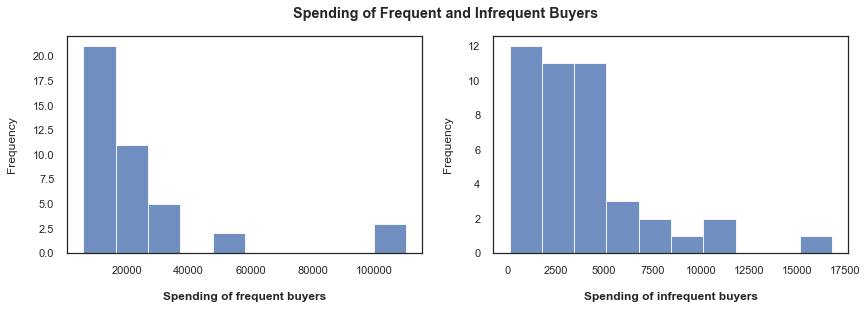

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.hist(above_median['Total Spend'], alpha=0.8)
ax1.set_xlabel('\nSpending of frequent buyers', fontweight='bold')
ax1.set_ylabel('Frequency\n')
ax2.hist(below_median['Total Spend'], alpha=0.8)
ax2.set_xlabel('\nSpending of infrequent buyers', fontweight='bold')
ax2.set_ylabel('Frequency\n')
plt.suptitle('Spending of Frequent and Infrequent Buyers\n', fontweight='bold');

Testing Homogeneity of Variance

In [75]:
# not homogeneous
stats.levene(above_median['Total Spend'], below_median['Total Spend'])

LeveneResult(statistic=10.714378797832683, pvalue=0.0015508441970941147)

Testing Normality 

In [76]:
#not normal
stats.shapiro(above_median['Total Spend'])

(0.6313993334770203, 4.911432149867778e-09)

In [77]:
#not normal
stats.shapiro(below_median['Total Spend'])

(0.8302197456359863, 1.7221949747181498e-05)

Welch's T Test 

In [78]:
#welch's t test, equal_variance = False 
descriptives, results = rp.ttest(above_median['Total Spend'], below_median['Total Spend'], equal_variances = False)
display(descriptives)
results

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Total Spend,42.0,25107.055667,24987.310326,3855.625690,17320.461644,32893.649689
1,Total Spend,43.0,4034.398291,3384.608614,516.147975,2992.769510,5076.027072
2,combined,85.0,14446.770171,20562.051784,2230.267654,10011.638355,18881.901986


,Welch's t-test,results
0,Difference (Total Spend - Total Spend) =,21072.6574
1,Degrees of freedom =,42.4694
2,t =,5.4171
3,Two side test p value =,0.0000
4,Difference > 0 p value =,1.0000
5,Difference < 0 p value =,0.0000
6,Cohen's d =,1.1752
7,Hedge's g =,1.1646
8,Glass's delta =,0.8433
9,r =,0.6392


In [79]:
#t-critical value 
print ('t-critical value:',t.ppf(1 - 0.05, df=42))

t-critical value: 1.6819523559426


In [80]:
power = TTestIndPower()
power_total_spend = power.power(effect_size=1.1888, nobs1=len(above_median['Total Spend']), alpha=alpha, ratio=len(below_median['Total Spend'])/len(above_median['Total Spend']), df=(len(above_median['Total Spend']) -1 + len(below_median['Total Spend'])-1), alternative='larger')
power_total_spend

0.9999999786997826

In [81]:
below_median.describe()

,Number of Orders,Total Spend
count,43.000000,43.000000
mean,11.441860,4034.398291
std,4.742424,3384.608614
min,2.000000,100.800000
25%,8.000000,1645.150000
50%,11.000000,3239.800000
75%,14.500000,4910.170000
max,20.000000,16817.097500


In [82]:
above_median.describe()

,Number of Orders,Total Spend
count,42.000000,42.000000
mean,37.761905,25107.055667
std,21.011970,24987.310326
min,21.000000,6089.900000
25%,25.250000,12374.360000
50%,31.000000,17492.007500
75%,39.750000,26224.314000
max,116.000000,110277.305000


- t value: 5.7497
- t-critical value: 1.6819523559426 
- p-value: 0.0000
- cohen's d: 1.1888, large effect
- power: 0.9999999786997826

> $H_0$: People who order more frequently do not spend more money on average than people who order less frequently.

> $H_1$: People who order more frequently spend more money on average than people who order less frequently.
    
The findings are significant! **We can reject the null hypothesis in support of the alternative.** The average spending of a frequent customer is much higher ($25,107) than the average spending of an infrequent customer ($4034.40). Cohen's D of 1.1888 tells us that being a frequent customer has a very strong impact on the amount customers spend. Frequent buyers spend more money, in general. 

The results could be used to develop effective marketing strategies targeting customers who - regardless of how much or how little they spend - make more frequent purchases on the whole, in order to generate higher revenues.

## Hypothesis Test 4 

## Employee Sales

> $H_0$: There is no difference in total sales between employees that make higher sales per order.

> $H_1$: There is a statistically significant difference in total sales between employees.

>$\alpha$ = 0.05

In [83]:
c.execute("""SELECT EmployeeId, FirstName || ' ' || LastName
               AS 'Name', Country, COUNT(OrderDetail.OrderId) AS 'Number of Sales',
               SUM(OrderDetail.Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*OrderDetail.Discount))) AS 'Total Sales'
               FROM [Order]
               LEFT OUTER JOIN Employee
               ON [Order].EmployeeId=Employee.Id
               LEFT OUTER JOIN OrderDetail
               ON [Order].Id=OrderDetail.OrderId
               GROUP BY EmployeeId
               ;""")
employee_dataframe = pd.DataFrame(c.fetchall())
employee_dataframe.columns = [x[0] for x in c.description]
display(employee_dataframe.head())
display(employee_dataframe.info())
display(employee_dataframe.describe())
np.shape(employee_dataframe)

,EmployeeId,Name,Country,Number of Sales,Total Sales
0,1,Nancy Davolio,USA,345,192107.6045
1,2,Andrew Fuller,USA,241,166537.7550
2,3,Janet Leverling,USA,321,202812.8430
3,4,Margaret Peacock,USA,420,232890.8460
4,5,Steven Buchanan,UK,117,68792.2825


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
EmployeeId         9 non-null int64
Name               9 non-null object
Country            9 non-null object
Number of Sales    9 non-null int64
Total Sales        9 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 440.0+ bytes


None

,EmployeeId,Number of Sales,Total Sales
count,9.000000,9.000000,9.000000
mean,5.000000,239.444444,140643.671056
std,2.738613,107.518732,61000.942334
min,1.000000,107.000000,68792.282500
25%,3.000000,168.000000,77308.066500
50%,5.000000,241.000000,126862.277500
75%,7.000000,321.000000,192107.604500
max,9.000000,420.000000,232890.846000


(9, 5)

In [84]:
employee_dataframe.isna().sum()

EmployeeId         0
Name               0
Country            0
Number of Sales    0
Total Sales        0
dtype: int64

In [85]:
employee_dataframe['Total Sales'] = round(employee_dataframe['Total Sales'],2)

In [86]:
employee_dataframe['Revenue Per Order'] = round(employee_dataframe['Total Sales']/employee_dataframe['Number of Sales'],2)

mean = round(np.mean(employee_dataframe['Number of Sales']),2)
median = np.median(employee_dataframe['Number of Sales'])
print(mean)
print(median)

employee_dataframe['Employee Performance'] = employee_dataframe['Number of Sales'].apply(lambda x: 'Below Average' 
                                                                           if x <= median 
                                                                           else 'Above Average')

display(employee_dataframe.head(9))
employee_dataframe.describe()

239.44
241.0


,EmployeeId,Name,Country,Number of Sales,Total Sales,Revenue Per Order,Employee Performance
0,1,Nancy Davolio,USA,345,192107.60,556.83,Above Average
1,2,Andrew Fuller,USA,241,166537.76,691.03,Below Average
2,3,Janet Leverling,USA,321,202812.84,631.82,Above Average
3,4,Margaret Peacock,USA,420,232890.85,554.50,Above Average
4,5,Steven Buchanan,UK,117,68792.28,587.97,Below Average
5,6,Michael Suyama,UK,168,73913.13,439.96,Below Average
6,7,Robert King,UK,176,124568.24,707.77,Below Average
7,8,Laura Callahan,USA,260,126862.28,487.93,Above Average
8,9,Anne Dodsworth,UK,107,77308.07,722.51,Below Average


,EmployeeId,Number of Sales,Total Sales,Revenue Per Order
count,9.000000,9.000000,9.000000,9.000000
mean,5.000000,239.444444,140643.672222,597.813333
std,2.738613,107.518732,61000.942109,98.824414
min,1.000000,107.000000,68792.280000,439.960000
25%,3.000000,168.000000,77308.070000,554.500000
50%,5.000000,241.000000,126862.280000,587.970000
75%,7.000000,321.000000,192107.600000,691.030000
max,9.000000,420.000000,232890.850000,722.510000


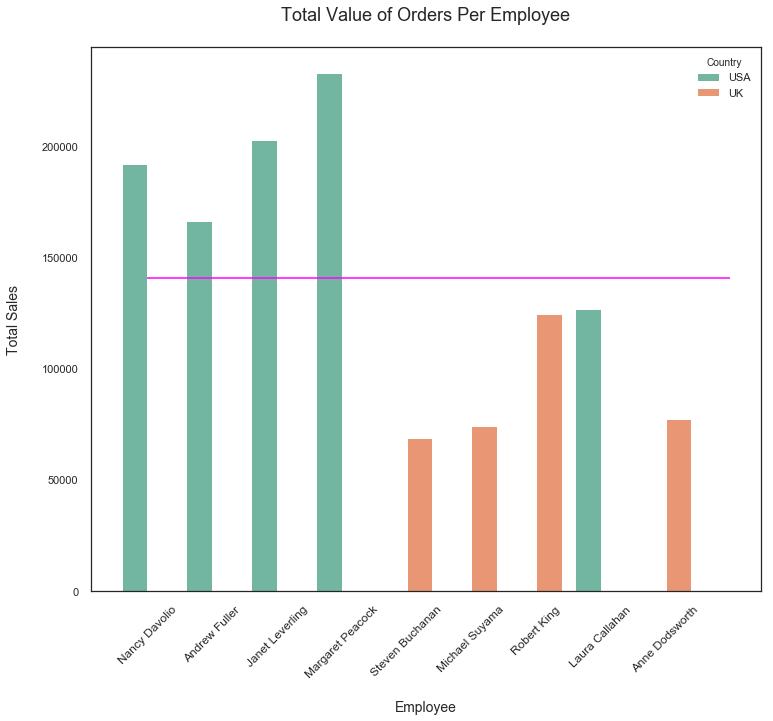

In [87]:
plt.figure(figsize=(12, 10))
sns.set_palette('Set2')
sns.barplot(employee_dataframe['Name'], employee_dataframe['Total Sales'], hue = employee_dataframe['Country'])
plt.hlines(y=employee_dataframe['Total Sales'].mean(), xmin=0, xmax=9, color='#FF00FF')
plt.title('Total Value of Orders Per Employee\n', fontsize = 18)
plt.xlabel('\nEmployee', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.ylabel('Total Sales\n', fontsize = 14)
plt.show();

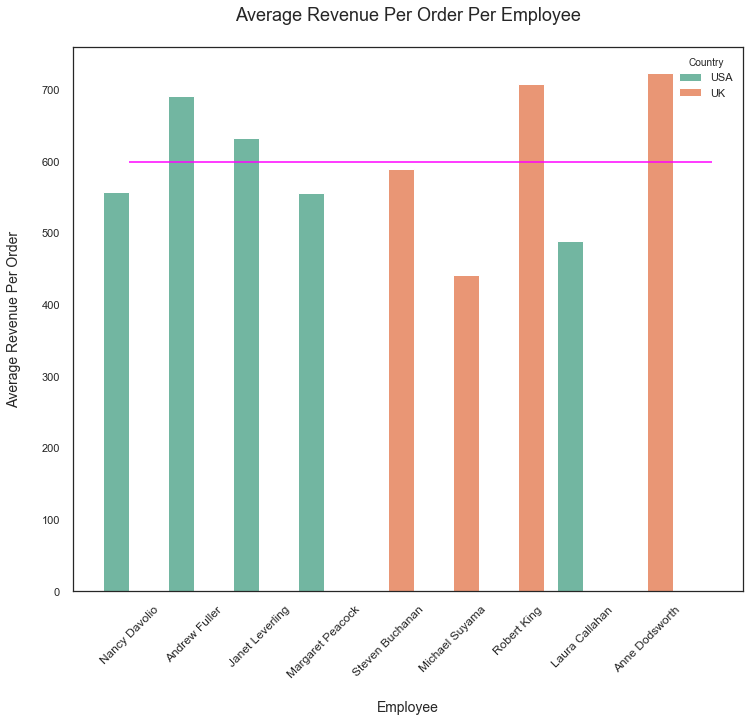

In [88]:
plt.figure(figsize=(12, 10))
sns.set_palette('Set2')
sns.barplot(employee_dataframe['Name'], employee_dataframe['Revenue Per Order'], hue = employee_dataframe['Country'])
plt.hlines(y=employee_dataframe['Revenue Per Order'].mean(), xmin=0, xmax=9, color='#FF00FF')
plt.title('Average Revenue Per Order Per Employee\n', fontsize = 18)
plt.xlabel('\nEmployee', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.ylabel('Average Revenue Per Order\n', fontsize = 14)
plt.show();

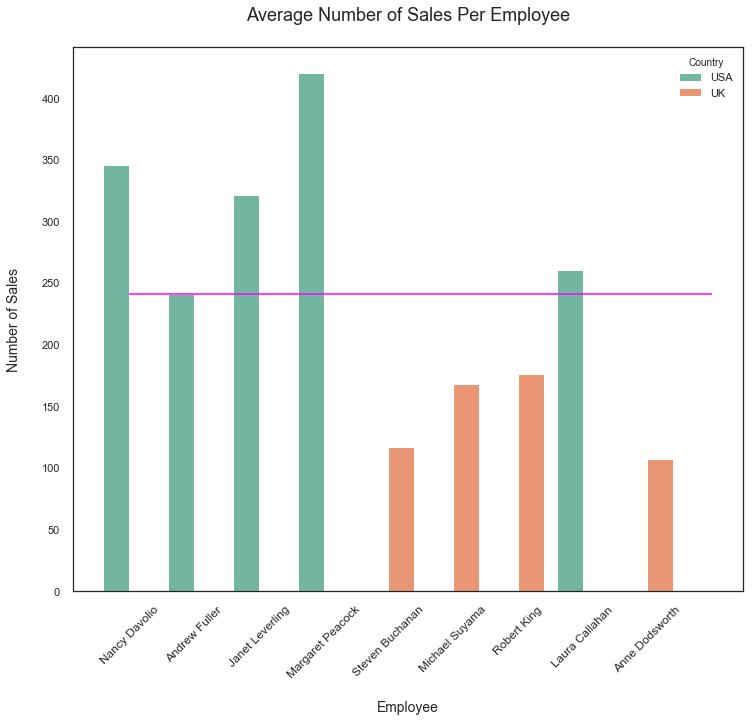

In [89]:
plt.figure(figsize=(12, 10))
sns.set_palette('Set2')
sns.barplot(employee_dataframe['Name'], employee_dataframe['Number of Sales'], hue = employee_dataframe['Country'])
plt.hlines(y=employee_dataframe['Number of Sales'].median(), xmin=0, xmax=9, color='#FF00FF')
plt.title('Average Number of Sales Per Employee\n', fontsize = 18)
plt.xlabel('\nEmployee', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.ylabel('Number of Sales\n', fontsize = 14)
plt.show();

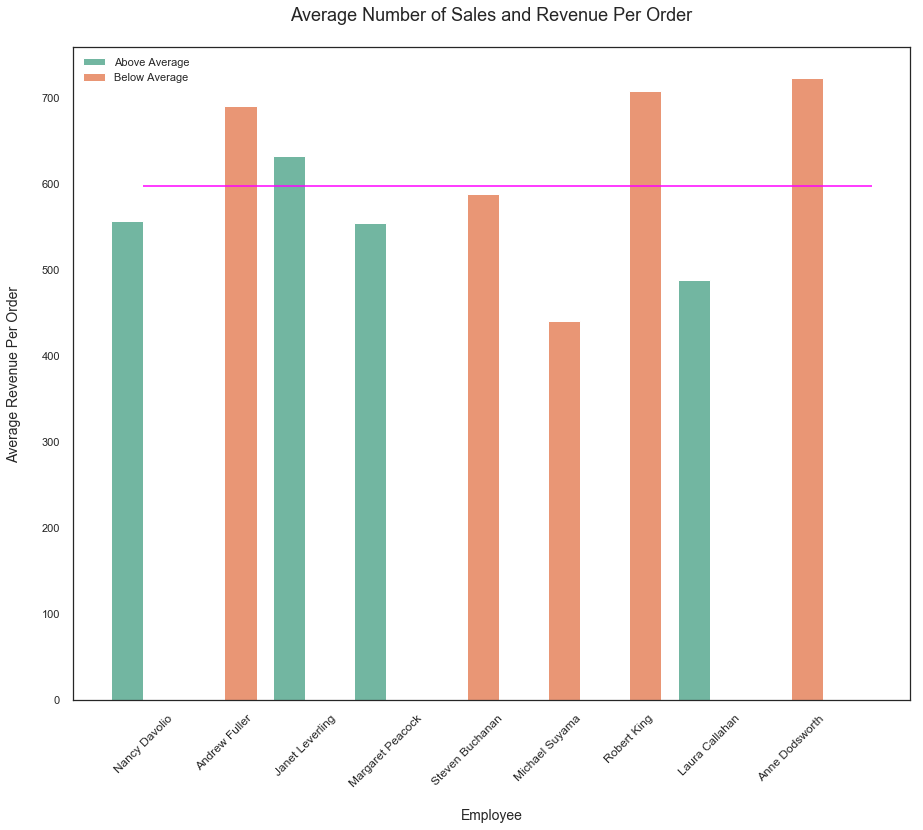

In [90]:
plt.figure(figsize=(15, 12))
sns.set_palette('Set2')
sns.barplot(employee_dataframe['Name'], employee_dataframe['Revenue Per Order'], hue = employee_dataframe['Employee Performance'])
plt.hlines(y=employee_dataframe['Revenue Per Order'].mean(), xmin=0, xmax=9, color='#FF00FF')
plt.title('Average Number of Sales and Revenue Per Order\n', fontsize = 18)
plt.xlabel('\nEmployee', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.ylabel('Average Revenue Per Order\n', fontsize = 14)
plt.legend(loc = 2)
plt.show();

In [91]:
below_average = employee_dataframe.loc[employee_dataframe['Employee Performance'] == 'Below Average']
above_average = employee_dataframe.loc[employee_dataframe['Employee Performance'] == 'Above Average']
display(below_average.head())
above_average.head()

,EmployeeId,Name,Country,Number of Sales,Total Sales,Revenue Per Order,Employee Performance
1,2,Andrew Fuller,USA,241,166537.76,691.03,Below Average
4,5,Steven Buchanan,UK,117,68792.28,587.97,Below Average
5,6,Michael Suyama,UK,168,73913.13,439.96,Below Average
6,7,Robert King,UK,176,124568.24,707.77,Below Average
8,9,Anne Dodsworth,UK,107,77308.07,722.51,Below Average


,EmployeeId,Name,Country,Number of Sales,Total Sales,Revenue Per Order,Employee Performance
0,1,Nancy Davolio,USA,345,192107.60,556.83,Above Average
2,3,Janet Leverling,USA,321,202812.84,631.82,Above Average
3,4,Margaret Peacock,USA,420,232890.85,554.50,Above Average
7,8,Laura Callahan,USA,260,126862.28,487.93,Above Average


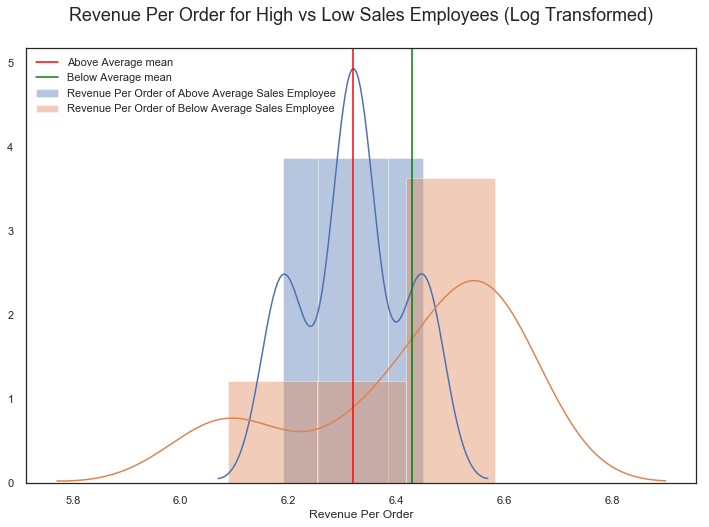

In [92]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('white')
sns.distplot(np.log(above_average['Revenue Per Order']), label='Revenue Per Order of Above Average Sales Employee')
sns.distplot(np.log(below_average['Revenue Per Order']), label='Revenue Per Order of Below Average Sales Employee')
plt.axvline(np.mean(np.log(above_average['Revenue Per Order'])), color='#FF0000', label='Above Average mean')
plt.axvline(np.mean(np.log(below_average['Revenue Per Order'])), color='#008000', label='Below Average mean')
plt.title('Revenue Per Order for High vs Low Sales Employees (Log Transformed)\n', fontsize = 18)
plt.legend()
plt.show();

In [93]:
#homogeneous
stats.levene(above_average['Revenue Per Order'], below_average['Revenue Per Order'])

LeveneResult(statistic=0.6302789861705104, pvalue=0.45332055537141774)

In [94]:
#normal
stats.shapiro(above_average['Revenue Per Order'])

(0.9502072334289551, 0.7174109816551208)

In [95]:
#normal
stats.shapiro(below_average['Revenue Per Order'])

(0.8354485630989075, 0.15272879600524902)

In [96]:
descriptives, results = rp.ttest(above_average['Revenue Per Order'], below_average['Revenue Per Order'], equal_variances = True)
display(descriptives)
results

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Revenue Per Order,4.0,557.770000,58.800807,29.400403,464.204795,651.335205
1,Revenue Per Order,5.0,629.848000,118.545920,53.015347,482.653799,777.042201
2,combined,9.0,597.813333,98.824414,32.941471,521.850164,673.776503


,Independent t-test,results
0,Difference (Revenue Per Order - Revenue Per Or...,-72.0780
1,Degrees of freedom =,7.0000
2,t =,-1.1017
3,Two side test p value =,0.3070
4,Difference > 0 p value =,0.1535
5,Difference < 0 p value =,0.8465
6,Cohen's d =,-0.7390
7,Hedge's g =,-0.6569
8,Glass's delta =,-1.2258
9,r =,0.3844


In [97]:
print ('t-critical value:',t.ppf(1 - 0.05, df=7))

t-critical value: 1.894578605061305


In [98]:
power = TTestIndPower()
power_employee_sales = power.power(effect_size=.7390, nobs1=len(above_average['Revenue Per Order']), alpha=alpha, ratio=len(below_average['Revenue Per Order'])/len(above_average['Revenue Per Order']), df=(len(above_average['Revenue Per Order']) -1 + len(below_average['Revenue Per Order'])-1), alternative='larger')
power_employee_sales

0.25837368305419806

In [99]:
below_average.describe()

,EmployeeId,Number of Sales,Total Sales,Revenue Per Order
count,5.000000,5.000000,5.000000,5.00000
mean,5.800000,161.800000,102223.896000,629.84800
std,2.588436,53.672153,42354.201729,118.54592
min,2.000000,107.000000,68792.280000,439.96000
25%,5.000000,117.000000,73913.130000,587.97000
50%,6.000000,168.000000,77308.070000,691.03000
75%,7.000000,176.000000,124568.240000,707.77000
max,9.000000,241.000000,166537.760000,722.51000


In [100]:
above_average.describe()

,EmployeeId,Number of Sales,Total Sales,Revenue Per Order
count,4.00000,4.000000,4.000000,4.000000
mean,4.00000,336.500000,188668.392500,557.770000
std,2.94392,66.174013,44674.805849,58.800807
min,1.00000,260.000000,126862.280000,487.930000
25%,2.50000,305.750000,175796.270000,537.857500
50%,3.50000,333.000000,197460.220000,555.665000
75%,5.00000,363.750000,210332.342500,575.577500
max,8.00000,420.000000,232890.850000,631.820000


- t value: -1.1017
- t-critical value: 1.894578605061305
- p-value: 0.3070
- cohen's d: -0.7390, medium to large effect
- power: 0.25837368305419806

> $H_0$: Employees who make higher numbers of sales do not make more revenue per order.

> $H_1$: There is a statistically significant difference in revenue per order for employees who make higher numbers of sales.
    
The findings are not significant! **We can fail to reject the null hypothesis and reject the alternative.** We find that employees who make higher than the median number of sales do not make more revenue per order on average. In fact, employees making above median number of sales have a lower average revenue per order. The mean revenue per order for 'high number of sales' employees is $557.77, while the average for employee with sales numbers below the median is $629.85. It is interesting to note that all the UK office employees have sales numbers below the median (241). Two employess hae average revenue per order above the mean ($597.81). Anne Dodsworth and Robert King have average revenue per order of $722.51 and $707.77. 

Margaret Peacock has the highest total number of sales (420) but only $554.50 average revenue per order. 

It is recommended to give all employees additional sales training and to re-evaluate and set new sales targets. The employees making higher than average revenue per order are encouraged to share best practices. 

The UK office overall makes fewer sales. Further investigation is needed to determine how to turn this around. 

## Business Recommendations

   > 1. There is not enough evidence to suggest the discounts significantly impact average order quantity or revenue per order. Discounts should be limited to increase full price sales. Discounts above 5% did not incentivize. Discounts, when given judiciously, should be capped at 5%. 
   > 2. Marketing prograrms to target customers who purchase more frequently, regardless of how much they spend, should be developed. These customers spend more than infrequent shoppers and can bring in more revenue. Further investigation can be done to determine what the right level of discount is to encourage frequent shoppers to spend more per order. 
   > 3. It is recommended to give all employees additional sales training and to re-evaluate and set new sales targets. The employees making higher than average revenue per order are encouraged to share best practices with underperforming teammates. The UK office overall makes fewer sales. Further investigation is needed to determine what causes this lower performance and how to turn this around.   